# Loan Application Risk and Process Analysis

**Project:** Loan Application Risk Analysis
**Author:** Khoi Tran

**Objective:** This notebook connects to the database, loads transformed data, and performs in-depth analyses to identify risks and evaluate process efficiency. All outputs and evidence are saved to the `output` directory.

In [9]:
# 1. ENVIRONMENT SETUP & CONFIGURATION
import os
import warnings
from urllib.parse import quote_plus

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
from IPython.display import display

# --- Global Configuration ---
OUTPUT_DIR = 'output'
DB_USER = 'root'
DB_PASS = 'Khoipioo2356@'
DB_HOST = 'localhost'
DB_PORT = '3306'
DB_NAME = 'loan_audit_db'

# --- Notebook Environment Settings ---
sns.set_theme(style="whitegrid", rc={"figure.figsize": (12, 8)})
warnings.filterwarnings('ignore')
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [10]:
# 2. HELPER FUNCTION DEFINITIONS
def plot_frequency(df, column, title, filename, top_n=15):
    """Plots and saves a frequency bar chart for a given data column."""
    counts = df[column].value_counts().nlargest(top_n)

    plt.figure() # Create a new figure to ensure correct sizing
    ax = sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Occurrences', fontsize=12)
    ax.set_ylabel(column.replace('_', ' ').title(), fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.show() # Display the plot directly in the notebook
    plt.close()

def analyze_segregation_of_duties(df):
    """Performs a Segregation of Duties (SoD) control test."""
    sod_activities = ['O_Create Offer', 'O_Sent (mail and online)']
    df_sod = df[df['Activity'].isin(sod_activities)]

    # Filter for cases that have both activities to ensure a valid test
    case_counts = df_sod.groupby('CaseID')['Activity'].nunique()
    valid_cases = case_counts[case_counts == 2].index
    df_sod = df_sod[df_sod['CaseID'].isin(valid_cases)]

    if df_sod.empty:
        print("SoD Test: No cases found containing both offer creation and sending activities. The test cannot be performed.")
        return

    # Pivot the data to compare the resources for each activity
    sod_pivot = df_sod.pivot_table(index='CaseID', columns='Activity', values='Resource', aggfunc='first')
    violations = sod_pivot.dropna()[sod_pivot[sod_activities[0]] == sod_pivot[sod_activities[1]]]

    if not violations.empty:
        print(f"SoD Test FINDING: {len(violations)} potential SoD violation(s) detected.")
        violations.to_csv(os.path.join(OUTPUT_DIR, '4_sod_violations.csv'))
        display(violations) # Display violations directly in the output
    else:
        print("SoD Test OK: No Segregation of Duties violations were found.")

In [11]:
# 3. DATABASE CONNECTION AND DATA LOADING
try:
    encoded_pass = quote_plus(DB_PASS)
    connection_string = f"mysql+mysqlconnector://{DB_USER}:{encoded_pass}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(connection_string)

    query = "SELECT * FROM loan_app_analytics_base_table"
    df = pd.read_sql(query, engine)

    print(f"Successfully loaded: {df.shape[0]:,} rows and {df.shape[1]} columns.")

    # Display the first 5 rows for verification
    display(df.head())

except Exception as e:
    print(f"ERROR: Could not load data from the database. Details: {e}")
    df = None

Successfully loaded: 1,202,267 rows and 8 columns.


,CaseID,Activity,Resource,LoanGoal,ApplicationType,Lifecycle,CreditScore,OfferedAmount
0,Application_652823628,A_Create Application,User_1,Existing loan takeover,New credit,complete,None,NaN
1,Application_652823628,A_Submitted,User_1,Existing loan takeover,New credit,complete,None,NaN
2,Application_652823628,W_Handle leads,User_1,Existing loan takeover,New credit,schedule,None,NaN
3,Application_652823628,W_Handle leads,User_1,Existing loan takeover,New credit,withdraw,None,NaN
4,Application_652823628,W_Complete application,User_1,Existing loan takeover,New credit,schedule,None,NaN


## Analysis A: Process Landscape Overview
**Objective:** To understand the most common activities and loan goals within the process.

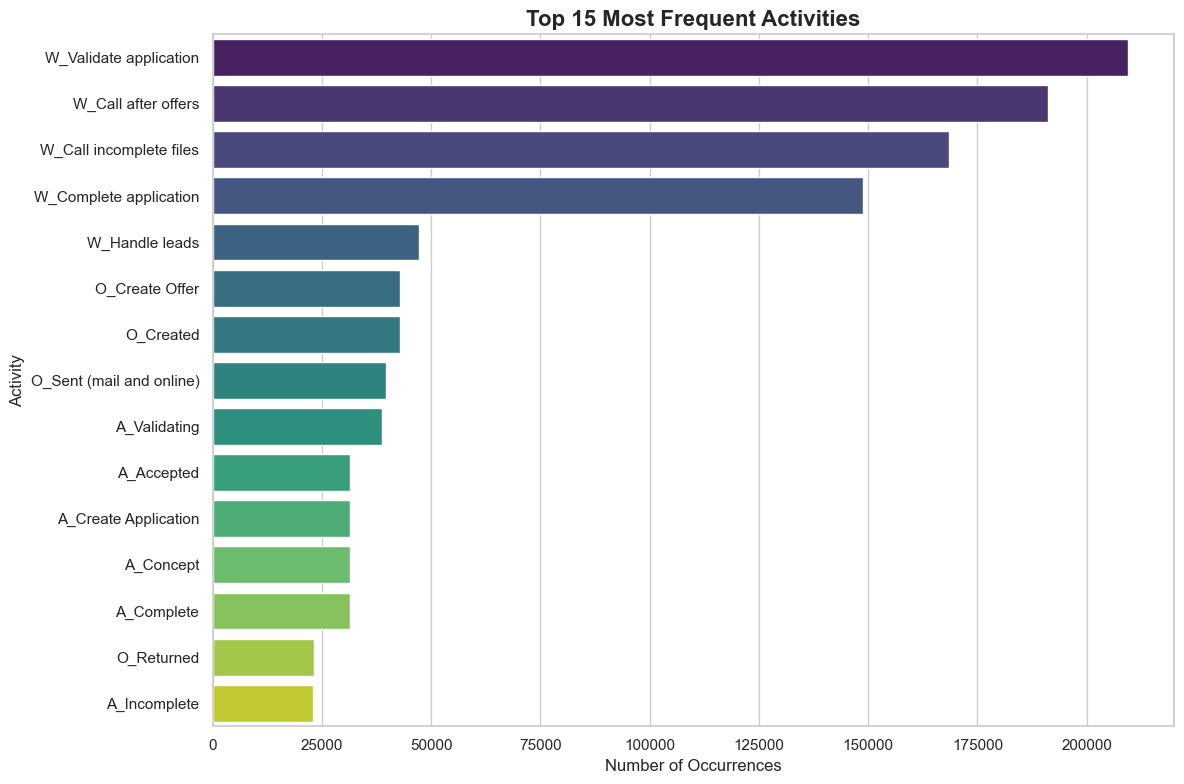

In [12]:
# 4. Chart: Top 15 Most Frequent Activities
if df is not None:
    plot_frequency(
        df,
        'Activity',
        'Top 15 Most Frequent Activities',
        '1_activity_frequency.png'
    )

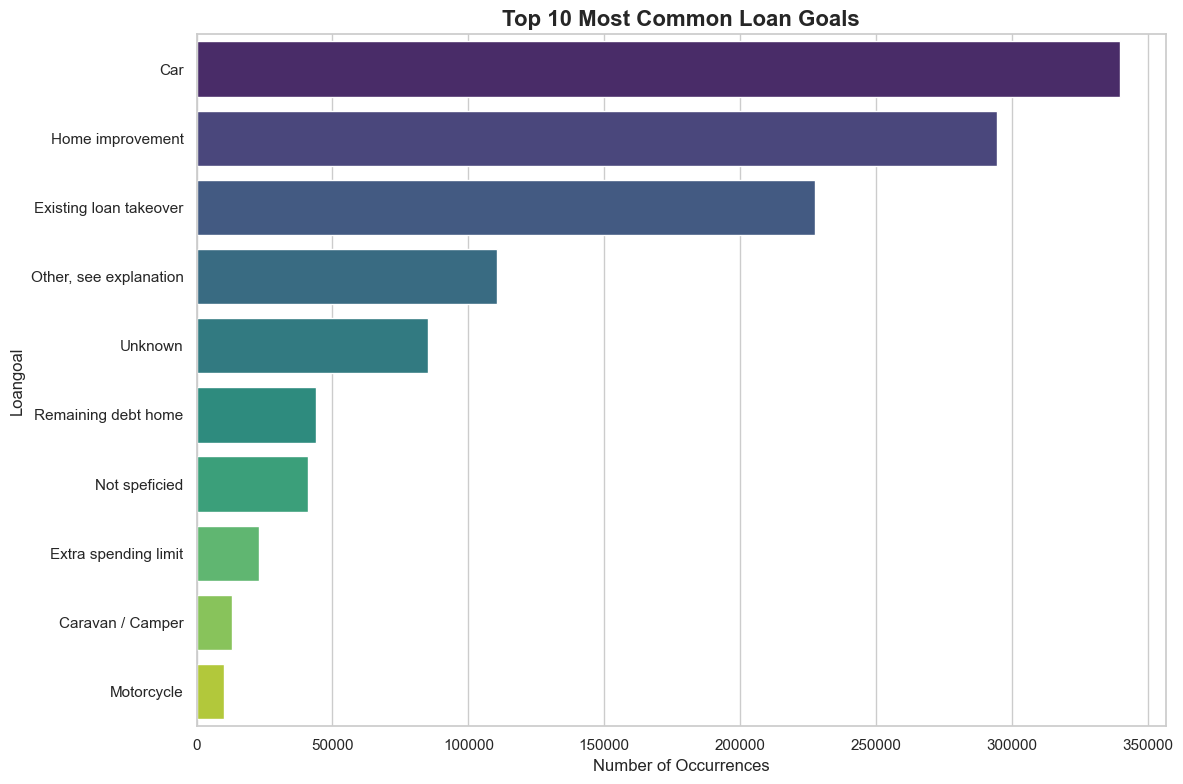

In [13]:
# 5. Chart: Top 10 Most Common Loan Goals
if df is not None:
    plot_frequency(
        df,
        'LoanGoal',
        'Top 10 Most Common Loan Goals',
        '2_loangoal_frequency.png',
        top_n=10
    )

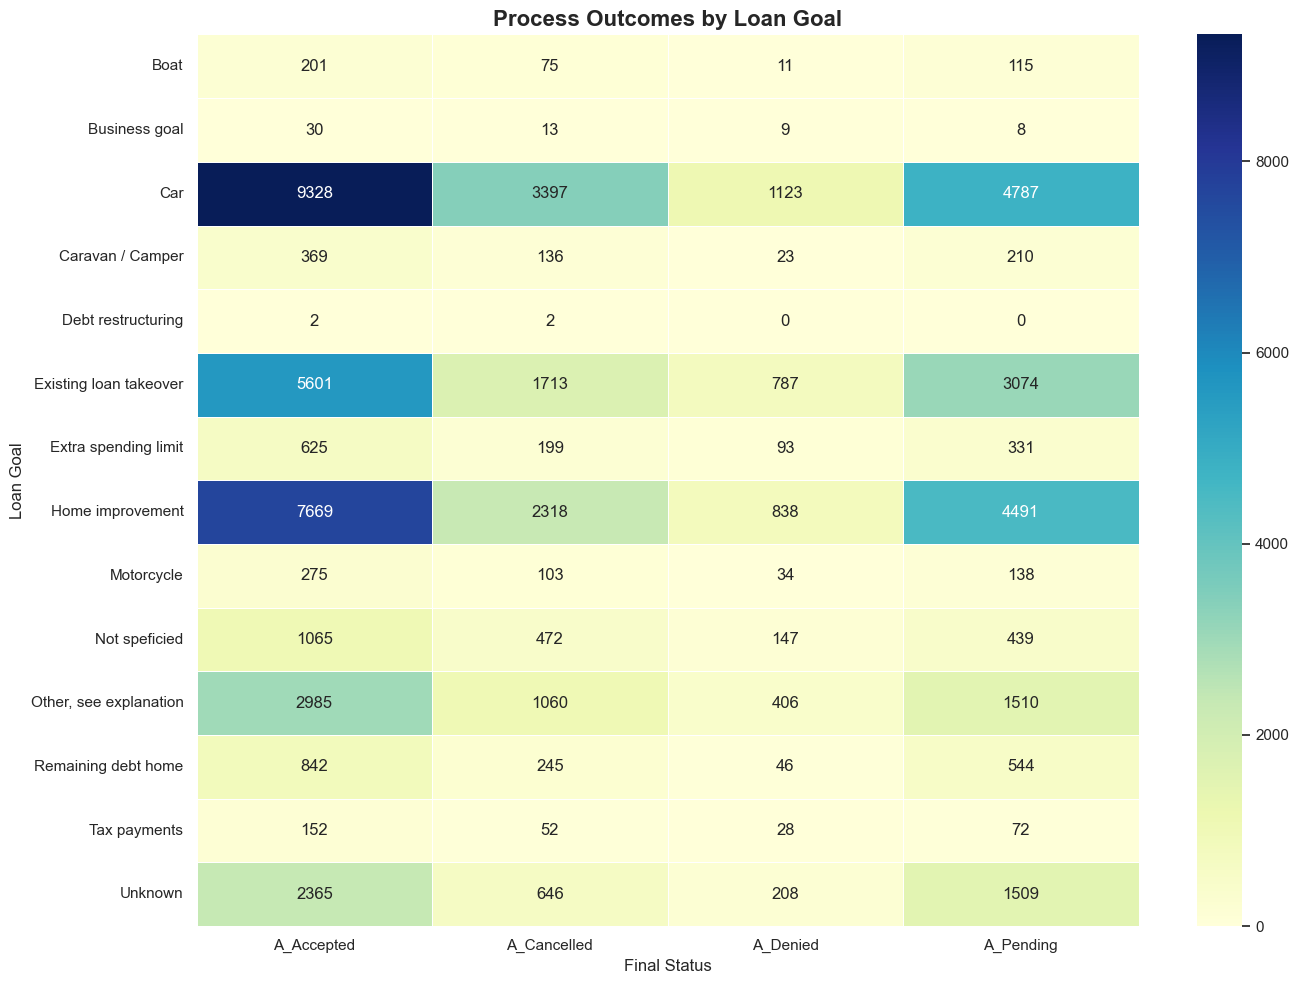

In [14]:
# 6. Heatmap: Relationship between Loan Goal and Final Outcome
if df is not None:
    final_activities = ['A_Pending', 'A_Denied', 'A_Cancelled', 'A_Accepted']
    df_final_state = df[df['Activity'].isin(final_activities)]

    if not df_final_state.empty:
        outcome_summary = pd.crosstab(df_final_state['LoanGoal'], df_final_state['Activity'])

        plt.figure(figsize=(14,10))
        sns.heatmap(outcome_summary, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
        plt.title('Process Outcomes by Loan Goal', fontsize=16, fontweight='bold')
        plt.ylabel('Loan Goal', fontsize=12)
        plt.xlabel('Final Status', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, '3_process_outcomes_heatmap.png'))
        plt.show()

        outcome_summary.to_csv(os.path.join(OUTPUT_DIR, '3_process_outcomes_summary.csv'))
    else:
        print("No final state data found for outcome analysis.")

In [15]:
# 7. Test: Segregation of Duties (SoD)
if df is not None:
    analyze_segregation_of_duties(df)

SoD Test FINDING: 30698 potential SoD violation(s) detected.


Activity,O_Create Offer,O_Sent (mail and online)
CaseID,,
Application_1000086665,User_5,User_5
Application_1000158214,User_32,User_32
Application_1000311556,User_71,User_71
Application_1000334415,User_91,User_91
Application_1000339879,User_28,User_28
...,...,...
Application_999487618,User_56,User_56
Application_999507989,User_16,User_16
Application_999544538,User_27,User_27
